In [1]:
# from tile_match_gym.tile_match_env import TileMatchEnv
import numpy as np
import gymnasium as gym
from gymnasium.envs.registration import register
from copy import deepcopy
from numba import njit
from tile_match_gym.tile_match_env import TileMatchEnv
from collections import defaultdict
# register(id="TileMatch-v0", entry_point="tile_match_gym.tile_match_env:TileMatchEnv")
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib import colors
from collections import OrderedDict
# % matplotlib inline
from tile_match_gym.wrappers import ProportionRewardWrapper, OneHotWrapper
import distinctipy
from PIL import Image
from IPython.display import clear_output

In [2]:
env = gym.make("TileMatch-v0", num_rows=5, num_colours=10, num_cols= 4, num_moves=10, colour_specials=["vertical_laser", "horizontal_laser", "bomb"], colourless_specials=["cookie"], render_mode="string")
env.reset()

(OrderedDict([('board',
               array([[[ 5,  6,  8, 10],
                       [ 1,  2,  9, 10],
                       [ 3,  4,  9,  5],
                       [ 3,  9,  3,  5],
                       [ 7,  6,  1,  1]],
               
                      [[ 1,  1,  1,  1],
                       [ 1,  1,  1,  1],
                       [ 1,  1,  1,  1],
                       [ 1,  1,  1,  1],
                       [ 1,  1,  1,  1]]])),
              ('num_moves_left', 10)]),
 {'effective_actions': [26]})

In [3]:
env.render()

 ---------
| 1 1 1 1 |
| 1 1 1 1 |
| 1 1 1 1 |
| 1 1 1 1 |
| 1 1 1 1 |
 ---------


c:\Users\ap2078\AppData\Local\miniconda3\envs\tile_match_gym\Lib\site-packages\gymnasium\utils\passive_env_checker.py:335: UserWarning: WARN: No render fps was declared in the environment (env.metadata['render_fps'] is None or not defined), rendering may occur at inconsistent fps.
  logger.warn(


In [4]:
colours[2]

NameError: name 'colours' is not defined

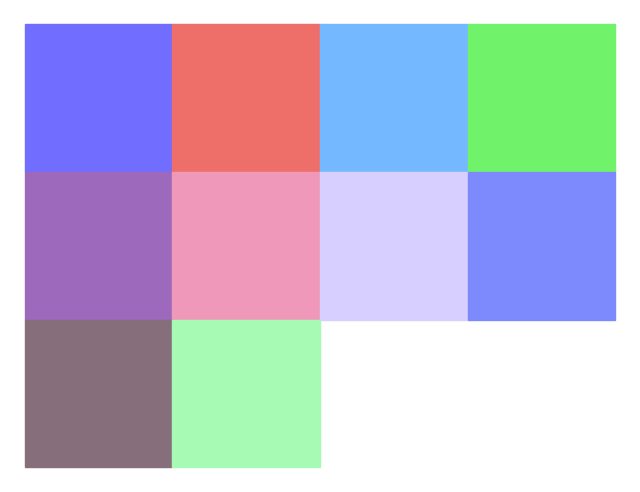

In [ ]:
distinctipy.color_swatch(colours)

In [6]:
import matplotlib.font_manager as fm
fm.list_fonts()

TypeError: list_fonts() missing 2 required positional arguments: 'directory' and 'extensions'

2 3
[[ 6.  7.  9. 11.]
 [ 2.  3. 10. 11.]
 [ 4.  5. 10.  1.]
 [ 4. 10.  4.  6.]
 [ 8.  7.  2.  2.]]


c:\Users\ap2078\AppData\Local\miniconda3\envs\tile_match_gym\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 127850 (\N{COOKIE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


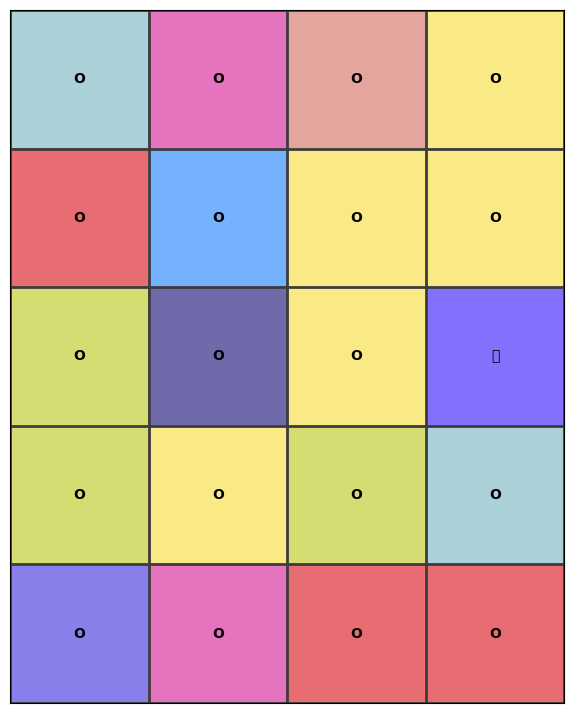

In [5]:

num_colours = 10
colours = distinctipy.get_colors(num_colours, colorblind_type="Deuteranopia", pastel_factor=0.7)
board = env.board.board
board[:, 2, 3] = np.array([0, -1])
print(board)
line_colour = np.array((60, 60, 60)) / 255
gray = np.array((255, 255, 255)) / 255
gray = [tuple(gray.tolist())]
render_colours  = np.array(gray + colours)

cmap = colors.ListedColormap(render_colours)
fig = plt.figure(num = "env_render", figsize=(12,9))
ax = plt.gca()
ax.clear()
clear_output(True)
# Colout agent position


colour_grid = np.zeros(board.shape[1:])

type_map = {
    1: "O",
    2: "|",
    3: "-",
    4: "💣",
    -1: "🍪"
}

# Colour terminal states

for r in range(colour_grid.shape[0]):
    for c in range(colour_grid.shape[1]):
        if board[0, r, c] == 0:
            print(r,c)
            colour_grid[r, c] = 1
        else:
            colour_grid[r, c] = board[0, r, c] + 1
        
        ax.annotate(type_map[board[1, r, c]], (c, r), va="center", ha="center", c="black", weight = "bold")
        


# Annotate initial_state
print(colour_grid)
# Annotate rewarding states
ax.imshow(colour_grid, cmap=cmap, vmin=0, vmax=num_colours)

ax.grid(which = 'major', axis = 'both', linestyle = '-', color = line_colour, linewidth = 2, zorder = 1)
ax.set_xticks(np.arange(-0.5, colour_grid.shape[1] , 1))
ax.set_xticklabels([])
ax.set_yticks(np.arange(-0.5, colour_grid.shape[0], 1))
ax.set_yticklabels([])
ax.tick_params(left=False, bottom=False)
plt.show()

In [10]:
print(board)

[[[ 5  6  8 10]
  [ 1  2  9 10]
  [ 3  4  9  5]
  [ 3  9  3  5]
  [ 7  6  1  1]]

 [[ 1  1  1  1]
  [ 1  1  1  1]
  [ 1  1  1  1]
  [ 1  1  1  1]
  [ 1  1  1  1]]]


In [ ]:
def moving_average(data, window_size):
    weights = np.repeat(1.0, window_size) / window_size
    return np.convolve(data, weights, 'valid')

In [ ]:
def run_episode(agent, env, obs_seen):
    obs, info = env.reset()
    done = False
    total_reward = 0
    num_effective_actions = 0
    
    obs_seen[agent._preprocess_obs(obs)] += 1
    while True:
        action = agent.choose_action(obs)
        next_obs, reward, done, _, info = env.step(action)
        obs_seen[agent._preprocess_obs(next_obs)] += 1
        agent.update(obs, action, reward, next_obs, done)
        num_effective_actions += int(reward > 0)
        total_reward += reward

        if done:
            break
        else:
            obs = next_obs
    return total_reward, num_effective_actions, obs_seen


def train(agent, num_episodes:int = 1000):
    env = gym.make("TileMatch", num_rows=3, num_cols=2, num_colours=2, num_moves=10, colour_specials=[], colourless_specials=[])
    env = ProportionRewardWrapper(env)
    epi_r = np.zeros(num_episodes)
    obs_seen = defaultdict(int)
    num_effective_actions_arr = np.zeros(num_episodes)
    num_shuffled = np.zeros(num_episodes)
    print_eps = True
    for i in tqdm(range(num_episodes)):
        total_reward, num_effective_actions, obs_seen = run_episode(agent, env, obs_seen)
        if agent.epsilon > 0.05:
            agent.epsilon *= 0.9999
        elif print_eps:
            print(f"Epsilon is low at episode {i}")
            print_eps = False
        epi_r[i] = total_reward
        num_effective_actions_arr[i] = num_effective_actions
    return epi_r, num_effective_actions_arr, obs_seen, agent

In [ ]:
class QLearningAgent:
    def __init__(self, lr, epsilon, gamma, num_actions, rng):
        self.lr = lr
        self.epsilon = epsilon
        self.gamma = gamma
        self.num_actions = num_actions
        self.q_table = defaultdict(lambda: np.zeros(self.num_actions, dtype=np.float32))
        self.rng = rng
        

    def choose_action(self, obs, effective_actions = None):
        s = self._preprocess_obs(obs)
        if self.rng.random() < self.epsilon:
            if effective_actions == None:
                return self.rng.choice(self.num_actions)
            else:
                return self.rng.choice(effective_actions)
        else:
            q_vals = self.q_table[s]
            if effective_actions != None:
                qs = q_vals[effective_actions]
                return effective_actions[self.rng.choice(np.flatnonzero(qs == qs.max()))]
            else:
                return self.rng.choice(np.flatnonzero(q_vals == q_vals.max()))
            
    def update(self, obs, action, reward, next_obs, done):
        s = self._preprocess_obs(obs)
        next_s = self._preprocess_obs(next_obs)
        q_vals = self.q_table[s]
        next_q_vals = self.q_table[next_s]
        q_target = reward + self.gamma * (1-done) * next_q_vals.max()
        self.q_table[s][action] += self.lr * ( q_target - q_vals[action])

    def _preprocess_obs(self, obs):
        board, num_moves = obs["board"], obs["num_moves_left"]
        o = board.flatten().tolist() + [num_moves]
        return tuple(o)
    
class RandomAgent:
    def __init__(self, num_actions, rng, use_effective_actions = False):
        self.num_actions = num_actions
        self.use_effective_actions = use_effective_actions
        self.rng = rng

    def choose_action(self, obs, *args, effective_actions=None, **kwargs):
        if self.use_effective_actions and effective_actions != None:
            return self.rng.choice(effective_actions)
        return self.rng.choice(range(self.num_actions))


def run_episode(agent, env, obs_seen):
    obs, info = env.reset()
    done = False
    total_reward = 0
    num_effective_actions = 0
    
    obs_seen[agent._preprocess_obs(obs)] += 1
    while True:
        action = agent.choose_action(obs)
        next_obs, reward, done, _, info = env.step(action)
        obs_seen[agent._preprocess_obs(next_obs)] += 1
        agent.update(obs, action, reward, next_obs, done)
        num_effective_actions += int(reward > 0)
        total_reward += reward
        if done:
            break
        else:
            obs = next_obs
    return total_reward, num_effective_actions, obs_seen


def train(agent, env, num_episodes:int = 1000):
    epi_r = np.zeros(num_episodes)
    obs_seen = defaultdict(int)
    num_effective_actions_arr = np.zeros(num_episodes)
    print_eps = True
    for i in tqdm(range(num_episodes)):
        total_reward, num_effective_actions, obs_seen = run_episode(agent, env, obs_seen)
        if agent.epsilon > 0.1:
            agent.epsilon *= 0.9999
        elif print_eps:
            print(f"Epsilon is low at episode {i}")
            print_eps = False
        epi_r[i] = total_reward
        num_effective_actions_arr[i] = num_effective_actions
    return epi_r, num_effective_actions_arr, obs_seen, agent

In [ ]:
rng = np.random.default_rng(0)
env = gym.make("TileMatch-v0", num_rows=3, num_cols=3, num_colours=2, num_moves=10, colour_specials=[], colourless_specials=[], seed=100)
env = ProportionRewardWrapper(env)
agent = QLearningAgent(lr=0.25, epsilon=1, gamma=0.7, num_actions=env.num_actions, rng=rng)
r, eff_a, obs_seen, agent = train(agent, env, 400_000)

c:\Users\ap2078\AppData\Local\miniconda3\envs\tile_match_gym\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.num_actions to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.num_actions` for environment variables or `env.get_wrapper_attr('num_actions')` that will search the reminding wrappers.
  logger.warn(
  6%|▌         | 23047/400000 [01:21<26:52, 233.75it/s]

Epsilon is low at episode 23025


100%|██████████| 400000/400000 [29:38<00:00, 224.93it/s]


In [ ]:
old_r, old_eff_a, old_obs_seen = deepcopy(r), deepcopy(eff_a), deepcopy(obs_seen)

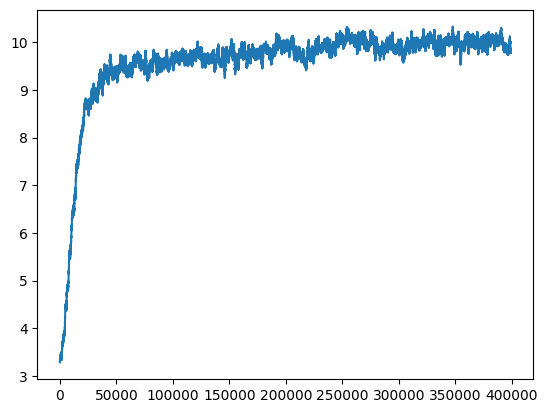

In [ ]:
plt.plot(moving_average(r, 800))

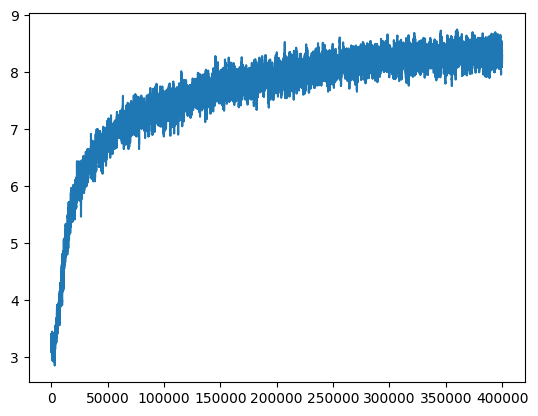

In [ ]:

plt.plot(moving_average(eff_a, 150))

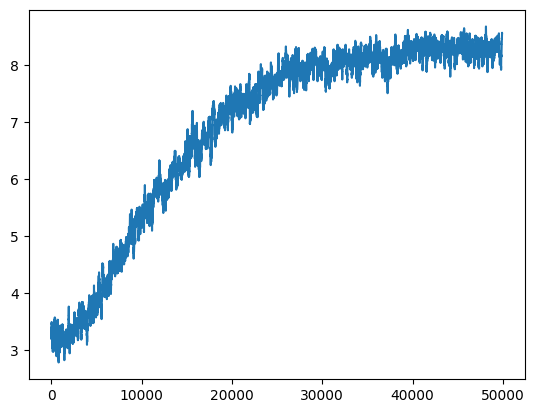

In [ ]:
plt.plot(moving_average(eff_a, 100))

In [ ]:
# Plot rolling averages.
# Run for longer to see if the agent explores enough.

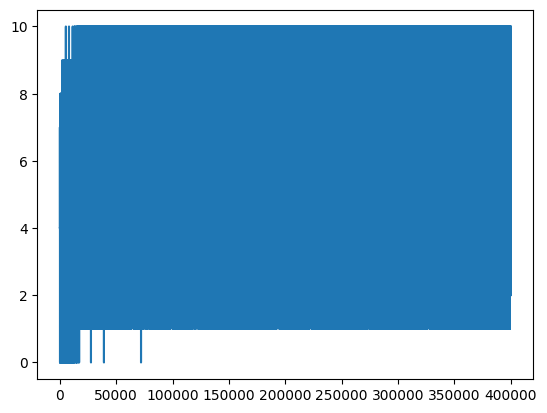

In [ ]:
plt.plot(eff_a)

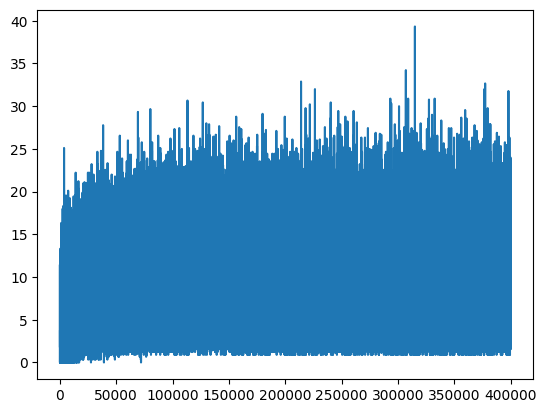

In [ ]:
plt.plot(r)

In [ ]:
obs_seen

defaultdict(int,
            {(2, 2, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 10): 4203,
             (2, 2, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 9): 3209,
             (1, 2, 2, 2, 2, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 4, 1, 1, 8): 342,
             (1, 2, 2, 1, 2, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 4, 1, 1, 7): 632,
             (1, 2, 1, 1, 1, 2, 2, 1, 2, 1, 1, 1, 1, 1, 1, 4, 1, 1, 6): 293,
             (1, 2, 1, 1, 1, 2, 2, 1, 2, 1, 1, 1, 1, 1, 1, 4, 1, 1, 5): 318,
             (1, 2, 1, 1, 1, 2, 2, 1, 2, 1, 1, 1, 1, 1, 1, 4, 1, 1, 4): 115,
             (1, 2, 1, 1, 1, 2, 2, 1, 2, 1, 1, 1, 1, 1, 1, 4, 1, 1, 3): 193,
             (1, 2, 1, 1, 1, 2, 2, 1, 2, 1, 1, 1, 1, 1, 1, 4, 1, 1, 2): 139,
             (2, 2, 1, 1, 1, 2, 2, 1, 2, 1, 1, 1, 1, 1, 1, 4, 1, 1, 1): 213,
             (2, 2, 1, 1, 1, 2, 2, 1, 2, 1, 1, 1, 1, 1, 1, 4, 1, 1, 0): 186,
             (1, 2, 1, 2, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 10): 4316,
             (1, 2, 1, 2, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1

In [ ]:
o = sorted(obs_seen.items(), key = lambda x : x[1], reverse=False)


In [ ]:
o

[((2, 1, 1, 1, 2, 2, 2, 1, 2, 4, 4, 1, 1, 1, 1, 1, 1, 1, 2), 1),
 ((2, 1, 2, 2, 1, 2, 1, 2, 1, 1, 1, 1, 1, 4, 4, 1, 1, 1, 7), 1),
 ((2, 2, 1, 1, 1, 2, 1, 2, 2, 1, 1, 4, 1, 4, 4, 1, 1, 1, 1), 1),
 ((2, 1, 2, 1, 2, 1, 1, 2, 2, 1, 1, 1, 4, 4, 1, 1, 1, 1, 2), 1),
 ((1, 2, 1, 2, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 4, 4, 1, 1, 9), 1),
 ((1, 2, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 4, 4, 1, 1, 2), 1),
 ((2, 1, 1, 1, 2, 2, 1, 2, 1, 1, 1, 1, 1, 1, 4, 1, 1, 4, 9), 1),
 ((1, 1, 2, 2, 2, 1, 1, 2, 2, 1, 1, 4, 1, 4, 1, 1, 4, 1, 2), 1),
 ((1, 1, 2, 2, 2, 1, 1, 2, 2, 1, 1, 4, 1, 4, 1, 1, 4, 1, 1), 1),
 ((1, 1, 2, 2, 2, 1, 1, 2, 2, 1, 1, 4, 1, 4, 1, 1, 4, 1, 0), 1),
 ((2, 1, 1, 1, 2, 1, 2, 1, 2, 1, 1, 1, 1, 4, 1, 4, 1, 1, 8), 1),
 ((2, 1, 1, 1, 2, 2, 2, 1, 2, 1, 1, 1, 1, 1, 4, 4, 1, 1, 7), 1),
 ((2, 1, 1, 1, 2, 2, 2, 1, 2, 1, 1, 1, 1, 1, 4, 4, 1, 1, 6), 1),
 ((2, 1, 2, 1, 2, 1, 2, 1, 1, 1, 4, 1, 1, 1, 4, 1, 1, 1, 0), 1),
 ((2, 1, 1, 1, 2, 2, 2, 1, 2, 1, 1, 4, 1, 1, 4, 1, 1, 4, 5), 1),
 ((2, 1, 1, 1, 2, 2, 2, 1

In [ ]:
agent.epsilon

0.04996170339735633

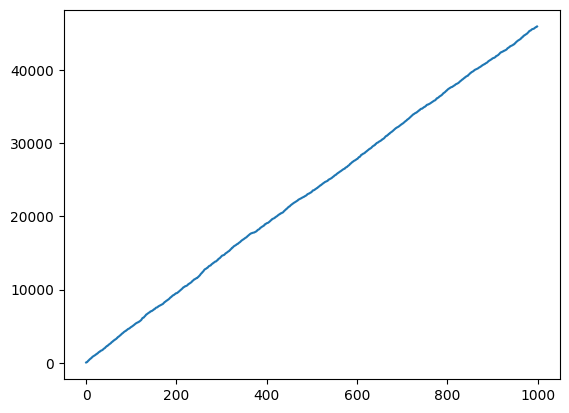

In [ ]:
plt.plot(np.cumsum(r))

In [ ]:
obs, info =  env.reset()
obs, info

(OrderedDict([('board',
               array([[[1, 2, 2],
                       [2, 1, 2],
                       [2, 1, 1]],
               
                      [[1, 1, 1],
                       [1, 1, 1],
                       [1, 1, 1]]])),
              ('num_moves_left', 10)]),
 {'effective_actions': [0, 1, 6]})

In [ ]:
agent.q_table[agent._preprocess_obs(obs)]

array([0. , 2.2, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
      dtype=float32)

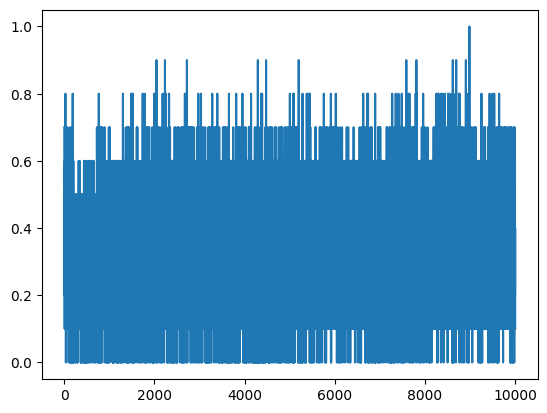

In [ ]:
plt.plot(eff_a / 10)

In [ ]:
env = TileMatchEnv(3, 3, 2, 5, [], [], 1)
env.reset()
env.board.board[0] = np.array([[1, 2, 2], [2, 1, 1], [2, 2, 1]])

effective_actions = env._get_effective_actions()
print(effective_actions)
assert effective_actions == [0, 6, 8]#

env = TileMatchEnv(3, 3, 2, 10, colour_specials=["vertical_laser", "horizontal_laser", "bomb"], colourless_specials=["cookie"])
env.reset()
env.board.board[0] = np.array([[1, 2, 2], [2, 1, 1], [2, 2, 1]])
assert effective_actions == [0, 6, 8]

[0, 6, 8]


In [ ]:
env.step(1)

(OrderedDict([('board',
               array([[[1, 2, 2],
                       [2, 1, 1],
                       [2, 2, 1]],
               
                      [[1, 1, 1],
                       [1, 1, 1],
                       [1, 1, 1]]])),
              ('num_moves_left', 9)]),
 0,
 False,
 False,
 {'is_combination_match': False,
  'num_new_specials': 0,
  'num_specials_activated': 0,
  'shuffled': False,
  'effective_actions': [0, 6, 8]})

In [ ]:
env.step(4)

(OrderedDict([('board',
               array([[[1, 1, 2],
                       [1, 1, 2],
                       [2, 2, 1]],
               
                      [[1, 1, 1],
                       [1, 1, 1],
                       [4, 4, 1]]])),
              ('num_moves_left', 6)]),
 16,
 False,
 False,
 {'is_combination_match': False,
  'num_new_specials': 2,
  'num_specials_activated': 0,
  'shuffled': False,
  'effective_actions': [5, 10, 11]})